In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const

In [105]:
Om_mat_cero = .3
Om_lambda_cero = .7
h = .7
#change these if you change the cosmology

In [106]:
def compute_abundance_matching_RodriguezPuebla(z, Mvirz):
    
    
    #Rodriguez-Puebla 2017
    #Relationship between initial DM halo and stellar mass 
    #Section 3.2 Parametrization of the SHMR (stellar to mass relation halo) Rodriguez-Puebla 2017
    #input: redshift, intial virial mass (halo)
    #units: Mvirz in solar mass
    #output; stellar mass for the given halo mass
    #units of solar mass
    
    
    M = Mvirz

    def P(x, y, z):
        return y*z - x*z/(1+z)

    def Q(z):
        return np.exp(-4/(1.+z)**2)

    def g(x, a, g, d):
        return (-np.log10(10**(-a*x)+1.) +
                d*(np.log10(1.+np.exp(x)))**g/(1.+np.exp(10**(-x))))

    al = (1.975, 0.714, 0.042)
    de = (3.390, -0.472, -0.931)
    ga = (0.498, -0.157)
    ep = (-1.758, 0.110, -0.061, -0.023)
    M0 = (11.548, -1.297, -0.026)

    #Section 5 Rodriguez-Puebla 2017
    #Constrains for the model. Madau & Dickinson (2014)
    
    alpha = al[0] + P(al[1], al[2], z) * Q(z)
    delta = de[0] + P(de[1], de[2], z) * Q(z)
    gamma = ga[0] + P(ga[1], 0, z) * Q(z)

    eps = 10**(ep[0] + P(ep[1], ep[2], z)*Q(z) + P(ep[3], 0, z))
    M1 = 10**(M0[0] + P(M0[1], M0[2], z)*Q(z))

    x = np.log10(M/M1)
    g1 = g(x, alpha, gamma, delta)
    g0 = g(0, alpha, gamma, delta)

    Ms = 10**(np.log10(eps*M1) + g1 - g0)
    
    

    return Ms


In [107]:
def halo_mass_assembly(Mvir0, z0, redshift): 
    
    #Growth of halos 
    #Apendix B2 Rodriguez-Puebla 2017
    #taken from Rodriguez-Puebla 2016a, Behroozi 2013b
    #Halo-mass assembly graph
    #inputs: Initial virial mass, redshift(0) initial time, redshift array
    #units: solar mass
    #output: halo mass growth 
    #units: solar mass
    
    z = redshift
  
    
    def M13(z):
        return (10**13.6) * (1+z)**2.755 * ((1+(z/2))**-6.351) * np.exp(-0.413*z)
    
    def aexp0(Mvir0):
        return 0.592 - np.log10(((10**15.7)/Mvir0)**0.113 + 1)

    def g(Mvir0, aexp):
        return 1. + np.exp(-3.676*(aexp-aexp0(Mvir0)))

    def f(Mvir0, z):
        aexp = 1. / (1+z)
        return np.log10((Mvir0)/M13(0.)) * (g(Mvir0, 1.)/g(Mvir0, aexp))
    
    def Mvir(Mvir0, z):
        return M13(z) * 10**(f(Mvir0, z))
        
    Mvir_z = Mvir(Mvir0, z-z0)
    
    return Mvir_z

  

The rate at which dark matter haloes grow will determine the rate at which the cosmological baryonic
inflow material reaches the ISM of a galaxy. Eventually, when necessary conditions are satisfied, some of 
this cosmological baryonic material will be transformed into stars. 
As described in Section 2.2, we use the growth of dark matter haloes to predict the SFHs of galaxies
without modelling how the cold gas in the galaxy is converted into stars.

In [108]:
def galaxy_mass_assembly(Mvir0, z0, z):
    #Halo growth and stellar relationship, galaxy mass evolution
    #inputs: Initial virial mass, redshift(0), redshift array
    #units solar mass
    #output: stellar mass growth within halo
    #units: solar mass
    
    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    Ms_z = compute_abundance_matching_RodriguezPuebla(z, Mvirz)
    
    return Ms_z


In [109]:
def AgeUniverse(Om_mat_cero, Om_lambda_cero, h, z):
    #output units of gyears
    #Hubble constant is H0 * h 
    

    T_Hubble = 1.02E-12

    H0 = 100

    one_plus_z = 1. + z

    Olz = Om_lambda_cero *one_plus_z**(-3)

    T1 = 2. / np.sqrt( Om_lambda_cero ) / 3. / H0 / T_Hubble / h

    T2 = np.sqrt(Olz)

    T3 = np.sqrt(Olz +  Om_mat_cero)

    TH = T1 * np.log( ( T2 + T3 ) / np.sqrt(Om_mat_cero) )

    return TH / 1E9
                                                                                 

In [110]:
def dMsdz(Mvir0, z0, redshift):
    #Stellar mass formation rate
    #Derivative of Galaxy mass assembly with respect to Age of Universe
    #input initial virial mass in solar mass
    #output units of solar masses per year
    #if you are using a diff cosmology be sure to change the constants below
    
    Om_mat_cero = .3
    
    Om_lambda_cero = .7
    
    h = .7
    
    z = np.array(redshift)
    
    zi = z
    
    zf = z - 0.01
    
    mi = galaxy_mass_assembly(Mvir0, z0, zi)
    
    mf = galaxy_mass_assembly(Mvir0, z0, zf)
    
    delm = mi - mf
    
    delz = zi - zf
    
    Ti = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zi)
    
    Tf = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zf)
    
    delT = Ti - Tf
    
    return delm / delT / 1E9


In [111]:
def R_stell_frac(Time):
    #Given by Aldo
    #fraction Stellar mass loss that comes back to ISM in form of gas
    
    
    C0 = 0.05
    
    lam = 1.46E5 #what is this number and what are the units
    
    time = Time * 1E9
    
    return C0*np.log(time/lam + 1.) #untiless, just a fraction


In [112]:
def SFR(Mvir0, z0, redshift):
    #Stellar mass formation rate corrected, stellar mass loss fraction included
    #Given by Aldo
    #input initial virial mass in solar mass
    #output units of solar masses per year
    
    TU = AgeUniverse(.3, .7, .7, redshift)
    #gotta change the values if I change the cosmology
    
    sfr_gal = dMsdz(Mvir0, z0, redshift) / (1. - R_stell_frac(TU))
    
    return sfr_gal


In [113]:
def Vmax(Mvir,z):
    #max value in DMhalo rotation curve
    #First step to introduce SN feedback
    #Rodriguez-Puebla 2016
    #Equations 4-7
    #input initial virial mass in solar mass
    #units out: km/s
    
    def alpha(z):
        
        aexp = 1. / (1+z)
        
        return 0.346 - 0.059*aexp + 0.025*aexp**2
    
    def beta(z):
        aexp = 1. / (1+z)
        return 10**(2.209 + 0.060*aexp - 0.021*aexp**2)
    
    def E(z):
        
        Om_mat_cero = .3
        
        Om_lambda_cero = .7
         #gotta change the values if I change the cosmology
        return np.sqrt(Om_lambda_cero + Om_mat_cero*(1 + z)**3)
    
    def V(Mvir, z):
        
        z = np.array(redshift)
        
        M12 = Mvir / 1E12
        
        return beta(z) * ( M12 * E(z) )**alpha(z)
    
    return V(Mvir,z)


In [114]:
def Vmax_assembly(Mvir0, z0, z):
    #Peak of the Halo rotation curve with halo mass growth
    #units input: solar mass
    #units outut: km/s

    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    vmax_z = Vmax(Mvirz, z)
    
    return vmax_z



In [115]:
def SNE_feedback(Mvir0, z0, z):
    #Given by Aldo
    #input unitls of solar mass
    #unitless, just a fraction
    
    EK = 0.5 * Vmax_assembly(Mvir0, z0, z)**2 
    #kitenic energy of the halo
    
    ESN = 10**7.701147 
    #units of solar mass km^2s^-2
    
    epsilon_SN = 0.05 #super nova efficiceny 
    
    N_SN = 8.0E-3 
    #SN/year
    
    E_SFR = SFR(Mvir0, z0, redshift) * ESN * epsilon_SN * N_SN
    #gotta check the units
    z = np.array(redshift)
    
    return E_SFR / EK



In [116]:
def v_disp(Mvir,z): 
    #First step to introduce SMBH 
    #relationship between velocity dispersion and SMBH due to its potential
    #velocity dispersion of DM halo
    #input units of solar mass
    #output untis of km/s
    
    vmax_x = Vmax(Mvir,z)
    
    return vmax_x / 3**0.5



In [117]:
def v_disp_assembly(Mvir0,z0,z):
    #Velocity dispersion of halo with mass halo growth
    #input units of solar mass
    #output units km/s
    
    Mvirz = halo_mass_assembly(Mvir0, z0, z)
    
    vdisp_z = v_disp(Mvirz, z)
    
    z = np.array(redshift)
    
    return vdisp_z


In [118]:
def M_BH(Mvir0, z0, z):
    #Black Hole mass relationship from velocity disperion sigma
    #Woo, Jong-Hak (2013)
    #units of solar mass both input and output
    
    sigma = v_disp_assembly(Mvir0,z0,z)
    
    alpha = 8.37
    
    beta = 5.31
    
    logM_BH = alpha + beta * np.log10(sigma/200) #check these units.
    
    M_BH = 10**logM_BH
    
    return M_BH


In [119]:
def dM_BHdz(Mvir0, z0, redshift):
    #Black Hole mass growth from velocity dispersion sigma 
    #input units of solar mass
    #output units of solar mass per year
    
    
    Om_mat_cero = .3
    #change these if you change the cosmology
    Om_lambda_cero = .7
    
    h = .7
    
    z = np.array(redshift)
    
    zi = z
    
    zf = z - 0.01
    
    mi = M_BH(Mvir0, z0, zi)
    
    mf = M_BH(Mvir0, z0, zf)
    
    delm = mi - mf
    
    delz = zi - zf
    
    Ti = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zi)
    
    Tf = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zf)
    
    delT = Ti - Tf
    
    return delm / delT / 1E9
    
        

In [120]:
def M_bh_from_MS(Mvir0, z0, z, fudge):
    #Blackhole mass aproximation from stellar mass (approx 100 times less than stellar mass)
    #Kormendy & Ho del 2013
    #units of solar mass both input and output
    

    Ms = galaxy_mass_assembly(Mvir0, z0, z)
    
    Mbh = Ms/fudge #fudge can be 1e2 or 1e3 
    
    return Mbh

In [121]:
def dM_bh_from_MS_dt(Mvir0, z0, z, fudge):
    #Black hole mass growth rate from stellar mass approximation 
    #fudge can be 1e2 or 1e3
    #output units of solar mass per year
    
   
    
    h = .7
    
    z = np.array(redshift)
    
    zi = z
    
    zf = z - 0.01
    
    mi = M_bh_from_MS(Mvir0, z0, zi, fudge)
    
    mf = M_bh_from_MS(Mvir0, z0, zf, fudge)
    
    delm = mi - mf
    
    delz = zi - zf
    
    Ti = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zi)
    
    Tf = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zf)
    
    delT = Ti - Tf
    
    return delm / delT / 1E9

In [122]:
def fQ(Ms,z):
    #Fraction of quenched galaxies as a function of stellar mass
    #Equation 44 from Rodriguez-Puebla et al. 2017.
    #input: Solar Mass
    #output: uniteless

    ratio = np.log10(Ms) - (10.2 + 0.6 * z)
    
    ratio = 10**(-1.3 * ratio)
    
    ratio = 1. + ratio
    
    return 1. / ratio

In [123]:
def fSF(Ms,z):
    #Fraction of star-forming galaxies as a function of stellar mass
    #FQ+FSF = 1.

    return 1. - fQ(Ms,z)

In [124]:
def Mbh_Ms_SF(Ms,z):
    #Blackhole mass - stellar mass relation for star-forming galaxies
    #Reines & Volonteri 2015.
    #input: Solar Mass
    #output: Solar Mass
    
    Mbh = 7.45 + 1.05 * ( np.log10(Ms) - 11.)
    
    Mbh = 10**Mbh

    return Mbh

In [125]:
def Mbh_Ms_Q(Ms,z):
    #Blackhole mass - stellar mass relation for quenched galaxies
    #Reines & Volonteri 2015.
    #input: Solar Mass
    #output: Solar Mass

    Mbh = 8.95 + 1.40 *  ( np.log10(Ms) - 11.)

    Mbh = 10**Mbh
    
    return Mbh

In [126]:
def M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0, z0, z):
    #Average Blackhole mass - stellar mass relation. Takes into account SFing and quenched galaxies.
    #We are assuming lognormal distributions for both SFing and quenched galaxies.
    #units of solar mass both input and output
    
    Ms = galaxy_mass_assembly(Mvir0, z0, z)

    Mbh = fQ(Ms,z) * np.log10(Mbh_Ms_Q(Ms,z))  + fSF(Ms,z) *  np.log10(Mbh_Ms_SF(Ms,z))
    
    Mbh = 10**Mbh

    return Mbh

In [127]:
def dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0, z0, redshift):
    #Black hole mass growth rate from the average Blackhole mass - stellar mass relation
    #output units of solar mass per year
    
    z = np.array(redshift)
    
    zi = z
    
    zf = z - 0.01
    
    mi = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0, z0, zi)
    
    mf = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0, z0, zf)
    
    delm = mi - mf
    
    delz = zi - zf
    
    Ti = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zi)
    
    Tf = AgeUniverse(Om_mat_cero, Om_lambda_cero, h, zf)
    
    delT = Ti - Tf
    
    return delm / delT / 1E9

In [184]:
def Lum_quasar_using_fraction_of_SF_and_quenched(Mvir0, z0, z):
    #Bolometric luminosoty of quasar given my SMBH accreting gas
    #Mbh/dt is in units are in solar mass per yr, and I need it g per sec
    
    solar = 1.99E33 #units of grams
    
    yr = (365*24*60*60) #units of seconds
    
    
    dMdt = dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0, z0, z) * solar / yr
    
    eps_acc = 0.1
    
    c = 3E10 #cm/s
    
    Lqso = ((eps_acc * c**2) / (1- eps_acc)) * dMdt
    
    #return Luminosity in units of erg*s^-1
    #erg = g*cm^2/s^2
    
    return Lqso

In [185]:
def Lum_quasar(Mvir0, z0, z, fudge):
    #Bolometric luminosoty of quasar given my SMBH accreting gas
    #Mbh/dt is in units are in solar mass per yr, and I need it g per sec
    #fudge can be 1e2 or 1e3
    
    solar = 1.99E33 #units of grams
    
    yr = (365*24*60*60) #units of seconds
    
    dMdt = dM_bh_from_MS_dt(Mvir0, z0, z, fudge) * solar / yr
    eps_acc = 0.1
    
    c = 3E10 #cm/s
    
    Lqso = ((eps_acc * c**2) / (1- eps_acc)) * dMdt
    
    #return Luminosity in units of erg*s^-1
    #erg = g*cm^2/s^2
    
    return Lqso   

In [186]:
def Lum_eddigton(Mvir0, z0, z, fudge):
    
    #units of ergs
    
    g = const.G.value * (100**3) /1000 #m^3/kgs^2 to cm^3/gs^2
    
    mp = const.m_p.value * 1000 #kg to grams
    
    c = const.c.value *100 #m to cm
    
    solar = 1.99E33 #units of grams
    
    sig = const.sigma_T.value *100**2 #m^2 to cm^2
    
    num = 4*np.pi* g * mp * c
    
    den = sig
    
    Mbh = M_bh_from_MS(Mvir0, z0, z, fudge) * solar
    
    return (num*Mbh) / den
    
    
    

In [187]:
def Lum_quasar_sigma(Mvir0, z0, z):
    #Bolometric luminosoty of quasar given my SMBH accreting gas
    #Mbh/dt is in units are in solar mass per yr, and I need it g per sec
    #fudge can be 1e2 or 1e3
    #input units of solar mass
    #output units of ergs per second
    
    
    solar = 1.99E33 #units of grams
    
    yr = (365*24*60*60)
    
    dMdt = dM_BHdz(Mvir0, z0, redshift) * solar / yr
    
    eps_acc = 0.1
    
    c = 3E10 #cm/s
    
    Lqso = ((eps_acc * c**2) / (1- eps_acc)) * dMdt
    
    #return Luminosity in units of erg*s^-1
    #erg = g*cm^2/s^2
    
    return Lqso 

In [188]:
def AGN_feedback(Mvir0, z0, z, fudge):
    #feedback due to AGN
    #Calculates energy from quasar and then it's divived by the kinetic 
    #of the halo
    #takes in units of ergs and it's divided...? are units right?
    
    eta = 0.008 #(croton+)
    
    KE = 0.5 * Vmax_assembly(Mvir0, z0, z)**2 #missing a mass, which one, and it should be cm s^-1
    
    E_qso = eta * Lum_quasar(Mvir0, z0, z, fudge)
    
    return E_qso / KE

In [161]:
# const.G.value * (100**3) /1000 
#print(g)
#const.m_p * 100
#const.c

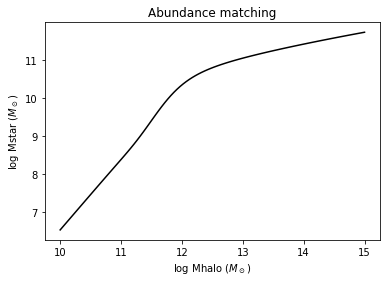

In [162]:
z0 = 0    
redshift = np.linspace (z0, 10, 100)
Mvir0 = (1e11, 1e12, 1e13, 1e14, 1e15)


Mhalo = np.logspace(10, 15, 100)
Ms = compute_abundance_matching_RodriguezPuebla(1, Mhalo)

plt.title('Abundance matching')
plt.plot(np.log10(Mhalo), np.log10(Ms), '-k')
plt.xlabel('log Mhalo ($M_\odot$)')
plt.ylabel('log Mstar ($M_\odot$)')
plt.show()

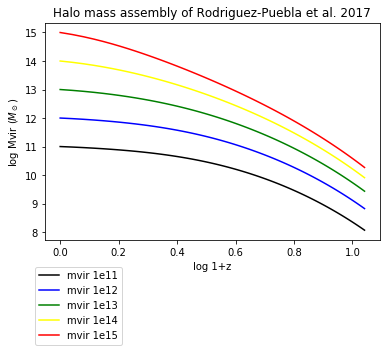

In [163]:
Mvirz = halo_mass_assembly(Mvir0[0], z0, redshift)
Mvirz2 = halo_mass_assembly(Mvir0[1], z0, redshift)
Mvirz3 = halo_mass_assembly(Mvir0[2], z0, redshift)
Mvirz4 = halo_mass_assembly(Mvir0[3], z0, redshift)
Mvirz5 = halo_mass_assembly(Mvir0[4], z0, redshift)

plt.title('Halo mass assembly of Rodriguez-Puebla et al. 2017')
plt.plot(np.log10(1+redshift), np.log10(Mvirz), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Mvirz2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Mvirz3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Mvirz4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Mvirz5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Mvir ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

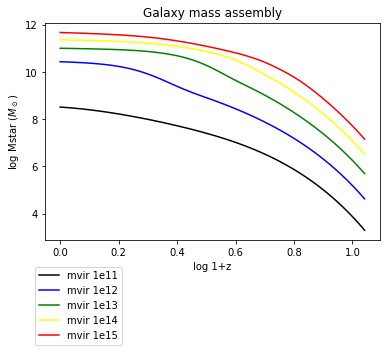

In [164]:
Ms_z = galaxy_mass_assembly(Mvir0[0], z0, redshift)
Ms_z2 = galaxy_mass_assembly(Mvir0[1], z0, redshift)
Ms_z3 = galaxy_mass_assembly(Mvir0[2], z0, redshift)
Ms_z4 = galaxy_mass_assembly(Mvir0[3], z0, redshift)
Ms_z5 = galaxy_mass_assembly(Mvir0[4], z0, redshift)

plt.title('Galaxy mass assembly')
plt.plot(np.log10(1+redshift), np.log10(Ms_z), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Ms_z2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Ms_z3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Ms_z4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Ms_z5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Mstar ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

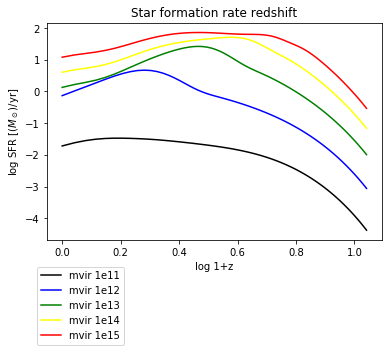

In [165]:
dmdz1 = dMsdz(Mvir0[0], z0, redshift)
dmdz2 = dMsdz(Mvir0[1], z0, redshift)
dmdz3 = dMsdz(Mvir0[2], z0, redshift)
dmdz4 = dMsdz(Mvir0[3], z0, redshift)
dmdz5 = dMsdz(Mvir0[4], z0, redshift)

plt.title('Star formation rate redshift')
plt.plot(np.log10(1+redshift), np.log10(dmdz1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(dmdz2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(dmdz3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(dmdz4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(dmdz5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log SFR [($M_\odot$)/yr]')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

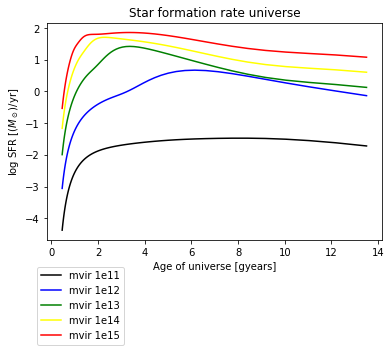

In [166]:
plt.title('Star formation rate universe')
plt.plot(AgeUniverse(.3, .7, .7, redshift), np.log10(dmdz1), '-k', color='black', label='mvir 1e11')
plt.plot(AgeUniverse(.3, .7, .7, redshift), np.log10(dmdz2), '-k', color='blue', label='mvir 1e12')
plt.plot(AgeUniverse(.3, .7, .7, redshift), np.log10(dmdz3), '-k', color='green', label='mvir 1e13')
plt.plot(AgeUniverse(.3, .7, .7, redshift), np.log10(dmdz4), '-k', color='yellow', label='mvir 1e14')
plt.plot(AgeUniverse(.3, .7, .7, redshift), np.log10(dmdz5), '-k', color='red', label='mvir 1e15')
plt.xlabel('Age of universe [gyears]')
plt.ylabel('log SFR [($M_\odot$)/yr]')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

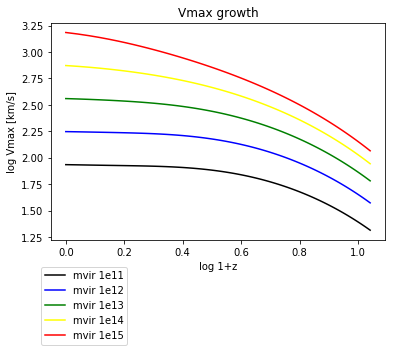

In [167]:
Vmax1 = Vmax_assembly(Mvir0[0],z0, redshift)
Vmax2 = Vmax_assembly(Mvir0[1],z0, redshift)
Vmax3 = Vmax_assembly(Mvir0[2],z0, redshift)
Vmax4 = Vmax_assembly(Mvir0[3],z0, redshift)
Vmax5 = Vmax_assembly(Mvir0[4],z0, redshift)

plt.title('Vmax growth')
plt.plot(np.log10(1+redshift), np.log10(Vmax1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Vmax2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Vmax3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Vmax4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Vmax5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Vmax [km/s]')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

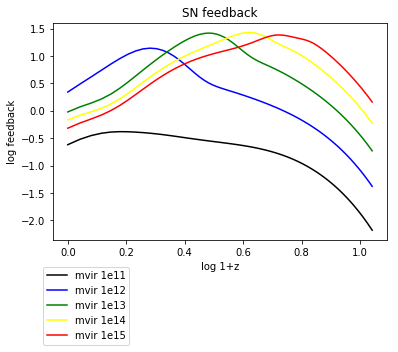

In [168]:
SNE_f1 = SNE_feedback(Mvir0[0], z0, redshift)
SNE_f2 = SNE_feedback(Mvir0[1], z0, redshift)
SNE_f3 = SNE_feedback(Mvir0[2], z0, redshift)
SNE_f4 = SNE_feedback(Mvir0[3], z0, redshift)
SNE_f5 = SNE_feedback(Mvir0[4], z0, redshift)

plt.title('SN feedback')
plt.plot(np.log10(1+redshift), np.log10(SNE_f1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(SNE_f2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(SNE_f3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(SNE_f4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(SNE_f5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log feedback')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

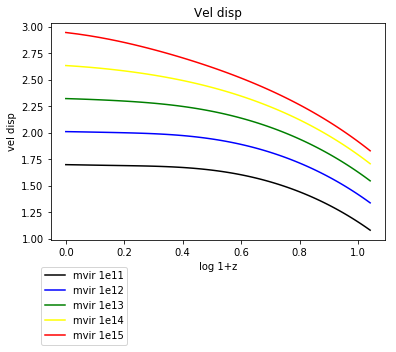

In [169]:
Vdisp1 = v_disp_assembly(Mvir0[0],z0, redshift)
Vdisp2 = v_disp_assembly(Mvir0[1],z0, redshift)
Vdisp3 = v_disp_assembly(Mvir0[2],z0, redshift)
Vdisp4 = v_disp_assembly(Mvir0[3],z0, redshift)
Vdisp5 = v_disp_assembly(Mvir0[4],z0, redshift)

plt.title('Vel disp')
plt.plot(np.log10(1+redshift), np.log10(Vdisp1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Vdisp2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Vdisp3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Vdisp4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Vdisp5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('vel disp')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

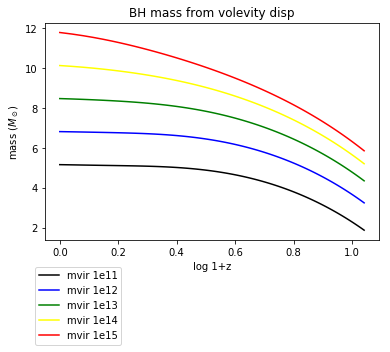

In [170]:
M_bh1 = M_BH(Mvir0[0],z0, redshift)
M_bh2 = M_BH(Mvir0[1],z0, redshift)
M_bh3 = M_BH(Mvir0[2],z0, redshift)
M_bh4 = M_BH(Mvir0[3],z0, redshift)
M_bh5 = M_BH(Mvir0[4],z0, redshift)

plt.title('BH mass from volevity disp')
plt.plot(np.log10(1+redshift), np.log10(M_bh1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

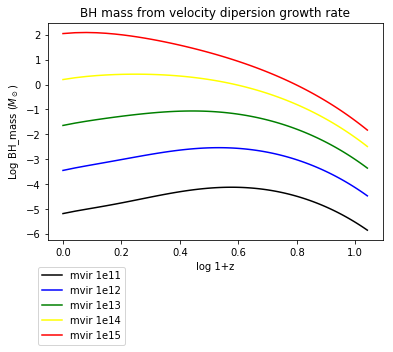

In [171]:
dM_bhdz1 = dM_BHdz(Mvir0[0],z0, redshift)
dM_bhdz2 = dM_BHdz(Mvir0[1],z0, redshift)
dM_bhdz3 = dM_BHdz(Mvir0[2],z0, redshift)
dM_bhdz4 = dM_BHdz(Mvir0[3],z0, redshift)
dM_bhdz5 = dM_BHdz(Mvir0[4],z0, redshift)

plt.title('BH mass from velocity dipersion growth rate')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('Log BH_mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

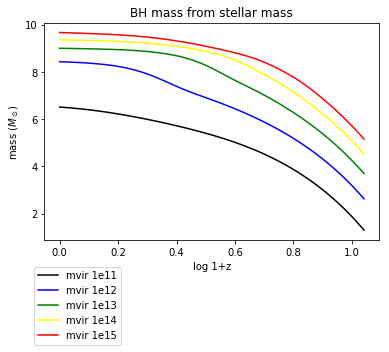

In [172]:
fudge2 = 1e2

M_bh_ms1 = M_bh_from_MS(Mvir0[0],z0, redshift, fudge2)
M_bh_ms2 = M_bh_from_MS(Mvir0[1],z0, redshift, fudge2)
M_bh_ms3 = M_bh_from_MS(Mvir0[2],z0, redshift, fudge2)
M_bh_ms4 = M_bh_from_MS(Mvir0[3],z0, redshift, fudge2)
M_bh_ms5 = M_bh_from_MS(Mvir0[4],z0, redshift, fudge2)

plt.title('BH mass from stellar mass')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

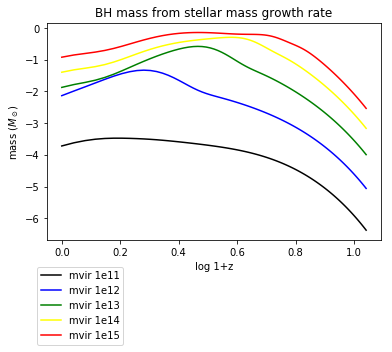

In [173]:
dM_bh_ms_dz1 = dM_bh_from_MS_dt(Mvir0[0],z0, redshift, fudge2)
dM_bh_ms_dz2 = dM_bh_from_MS_dt(Mvir0[1],z0, redshift, fudge2)
dM_bh_ms_dz3 = dM_bh_from_MS_dt(Mvir0[2],z0, redshift, fudge2)
dM_bh_ms_dz4 = dM_bh_from_MS_dt(Mvir0[3],z0, redshift, fudge2)
dM_bh_ms_dz5 = dM_bh_from_MS_dt(Mvir0[4],z0, redshift, fudge2)

plt.title('BH mass from stellar mass growth rate')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

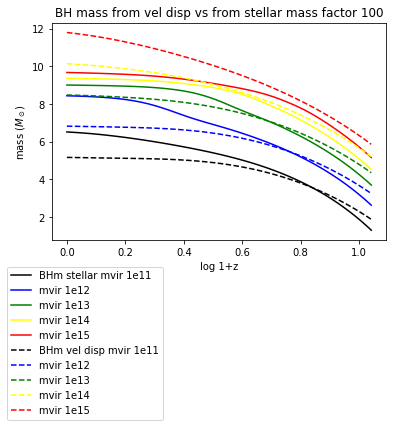

In [174]:
fudge = 1e3

M_bh_mse31 = M_bh_from_MS(Mvir0[0],z0, redshift, fudge)
M_bh_mse32 = M_bh_from_MS(Mvir0[1],z0, redshift, fudge)
M_bh_mse33 = M_bh_from_MS(Mvir0[2],z0, redshift, fudge)
M_bh_mse34 = M_bh_from_MS(Mvir0[3],z0, redshift, fudge)
M_bh_mse35 = M_bh_from_MS(Mvir0[4],z0, redshift, fudge)

plt.title('BH mass from vel disp vs from stellar mass factor 100')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms1), '-', color='black', label='BHm stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh_ms5), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(M_bh1), '--', color='black', label='BHm vel disp mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh2), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh3), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh4), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh5), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

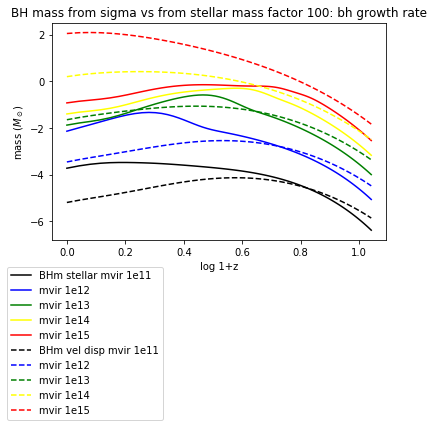

In [175]:
plt.title('BH mass from sigma vs from stellar mass factor 100: bh growth rate')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz1), '-', color='black', label='BHm stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz5), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz1), '--', color='black', label='BHm vel disp mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz2), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz3), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz4), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(dM_bhdz5), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()


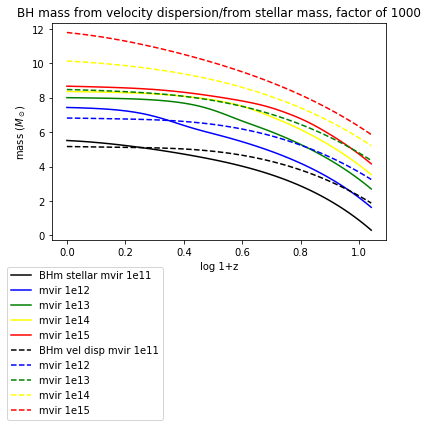

In [176]:
plt.title('BH mass from velocity dispersion/from stellar mass, factor of 1000')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse31), '-', color='black', label='BHm stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse32), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse33), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse34), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse35), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(M_bh1), '--', color='black', label='BHm vel disp mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh2), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh3), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh4), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh5), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show() 

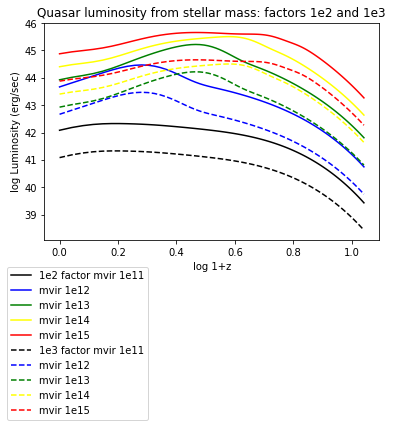

In [177]:
Lum_q1 = Lum_quasar(Mvir0[0], z0, redshift, fudge2)
Lum_q2 = Lum_quasar(Mvir0[1], z0, redshift, fudge2)
Lum_q3 = Lum_quasar(Mvir0[2], z0, redshift, fudge2)
Lum_q4 = Lum_quasar(Mvir0[3], z0, redshift, fudge2)
Lum_q5 = Lum_quasar(Mvir0[4], z0, redshift, fudge2)

Lum_q31 = Lum_quasar(Mvir0[0], z0, redshift, fudge)
Lum_q32 = Lum_quasar(Mvir0[1], z0, redshift, fudge)
Lum_q33 = Lum_quasar(Mvir0[2], z0, redshift, fudge)
Lum_q34 = Lum_quasar(Mvir0[3], z0, redshift, fudge)
Lum_q35 = Lum_quasar(Mvir0[4], z0, redshift, fudge)

plt.title('Quasar luminosity from stellar mass: factors 1e2 and 1e3')
plt.plot(np.log10(1+redshift), np.log10(Lum_q1), '-', color='black', label='1e2 factor mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_q2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_q3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_q4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_q5), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(Lum_q31), '--', color='black', label='1e3 factor mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_q32), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_q33), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_q34), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_q35), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Luminosity (erg/sec)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

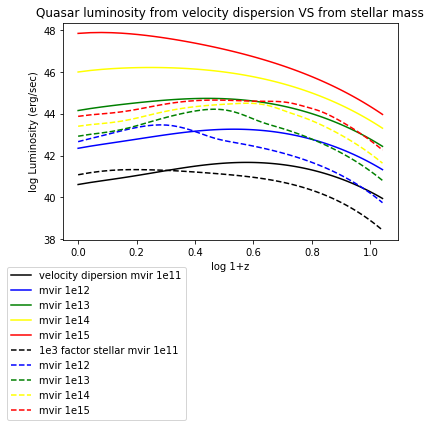

In [178]:
Lum_q_s1= Lum_quasar_sigma(Mvir0[0], z0, redshift)
Lum_q_s2= Lum_quasar_sigma(Mvir0[1], z0, redshift)
Lum_q_s3= Lum_quasar_sigma(Mvir0[2], z0, redshift)
Lum_q_s4= Lum_quasar_sigma(Mvir0[3], z0, redshift)
Lum_q_s5= Lum_quasar_sigma(Mvir0[4], z0, redshift)

plt.title('Quasar luminosity from velocity dispersion VS from stellar mass')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s1), '-', color='black', label='velocity dipersion mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s5), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(Lum_q31), '--', color='black', label='1e3 factor stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_q32), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_q33), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_q34), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_q35), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Luminosity (erg/sec)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

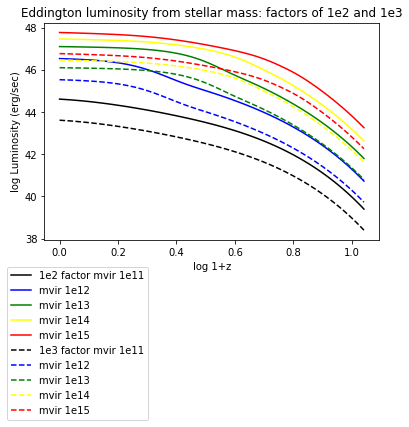

In [179]:
Lum_ed1 = Lum_eddigton(Mvir0[0], z0, redshift, fudge2)
Lum_ed2 = Lum_eddigton(Mvir0[1], z0, redshift, fudge2)
Lum_ed3 = Lum_eddigton(Mvir0[2], z0, redshift, fudge2)
Lum_ed4 = Lum_eddigton(Mvir0[3], z0, redshift, fudge2)
Lum_ed5 = Lum_eddigton(Mvir0[4], z0, redshift, fudge2)

Lum_ed31 = Lum_eddigton(Mvir0[0], z0, redshift, fudge)
Lum_ed32 = Lum_eddigton(Mvir0[1], z0, redshift, fudge)
Lum_ed33 = Lum_eddigton(Mvir0[2], z0, redshift, fudge)
Lum_ed34 = Lum_eddigton(Mvir0[3], z0, redshift, fudge)
Lum_ed35 = Lum_eddigton(Mvir0[4], z0, redshift, fudge)

plt.title('Eddington luminosity from stellar mass: factors of 1e2 and 1e3')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed1), '-', color='black', label='1e2 factor mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed5), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed31), '--', color='black', label='1e3 factor mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed32), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed33), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed34), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_ed35), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Luminosity (erg/sec)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

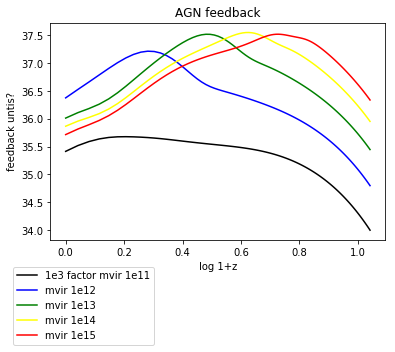

In [180]:
agn_fb1 = AGN_feedback(Mvir0[0], z0, redshift, fudge)
agn_fb2 = AGN_feedback(Mvir0[1], z0, redshift, fudge)
agn_fb3 = AGN_feedback(Mvir0[2], z0, redshift, fudge)
agn_fb4 = AGN_feedback(Mvir0[3], z0, redshift, fudge)
agn_fb5 = AGN_feedback(Mvir0[4], z0, redshift, fudge)

plt.title('AGN feedback')
plt.plot(np.log10(1+redshift), np.log10(agn_fb1), '-', color='black', label='1e3 factor mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(agn_fb2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(agn_fb3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(agn_fb4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(agn_fb5), '-', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('feedback untis?')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

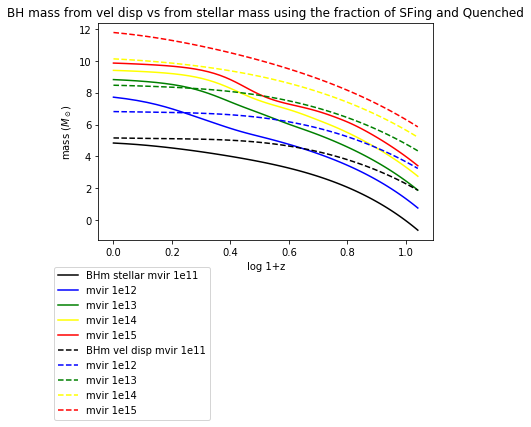

In [181]:
M_bh_mse31 = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[0],z0, redshift,)
M_bh_mse32 = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[1],z0, redshift)
M_bh_mse33 = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[2],z0, redshift)
M_bh_mse34 = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[3],z0, redshift)
M_bh_mse35 = M_bh_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[4],z0, redshift)

plt.title('BH mass from vel disp vs from stellar mass using the fraction of SFing and Quenched')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse31), '-', color='black', label='BHm stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse32), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse33), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse34), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh_mse35), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(M_bh1), '--', color='black', label='BHm vel disp mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(M_bh2), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(M_bh3), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(M_bh4), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(M_bh5), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('mass ($M_\odot$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()


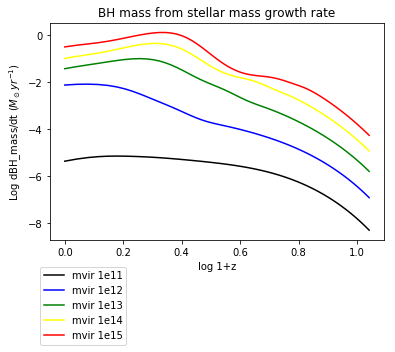

In [182]:
dM_bh_ms_dz1 = dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[0],z0, redshift)
dM_bh_ms_dz2 = dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[1],z0, redshift)
dM_bh_ms_dz3 = dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[2],z0, redshift)
dM_bh_ms_dz4 = dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[3],z0, redshift)
dM_bh_ms_dz5 = dM_bh_dt_from_Ms_using_fraction_of_SF_and_quenched(Mvir0[4],z0, redshift)

plt.title('BH mass from stellar mass growth rate')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz1), '-k', color='black', label='mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz2), '-k', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz3), '-k', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz4), '-k', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(dM_bh_ms_dz5), '-k', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('Log dBH_mass/dt ($M_\odot yr^{-1}$)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

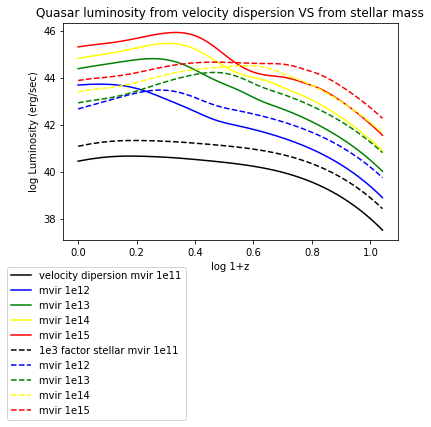

In [189]:
Lum_q_s1= Lum_quasar_using_fraction_of_SF_and_quenched(Mvir0[0], z0, redshift)
Lum_q_s2= Lum_quasar_using_fraction_of_SF_and_quenched(Mvir0[1], z0, redshift)
Lum_q_s3= Lum_quasar_using_fraction_of_SF_and_quenched(Mvir0[2], z0, redshift)
Lum_q_s4= Lum_quasar_using_fraction_of_SF_and_quenched(Mvir0[3], z0, redshift)
Lum_q_s5= Lum_quasar_using_fraction_of_SF_and_quenched(Mvir0[4], z0, redshift)

plt.title('Quasar luminosity from velocity dispersion VS from stellar mass')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s1), '-', color='black', label='velocity dipersion mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s2), '-', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s3), '-', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s4), '-', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_q_s5), '-', color='red', label='mvir 1e15')
plt.plot(np.log10(1+redshift), np.log10(Lum_q31), '--', color='black', label='1e3 factor stellar mvir 1e11')
plt.plot(np.log10(1+redshift), np.log10(Lum_q32), '--', color='blue', label='mvir 1e12')
plt.plot(np.log10(1+redshift), np.log10(Lum_q33), '--', color='green', label='mvir 1e13')
plt.plot(np.log10(1+redshift), np.log10(Lum_q34), '--', color='yellow', label='mvir 1e14')
plt.plot(np.log10(1+redshift), np.log10(Lum_q35), '--', color='red', label='mvir 1e15')
plt.xlabel('log 1+z')
plt.ylabel('log Luminosity (erg/sec)')
plt.legend(loc=9, bbox_to_anchor=(0.1, -0.1), ncol=1)
plt.show()

In [ ]:
#https://plot.ly/python/contour-plots/
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contour.html
#http://gnuplot.sourceforge.net/demo/heatmaps.7.gnu